<a href="https://colab.research.google.com/github/Farmhouse121/Adventures-in-Financial-Data-Science/blob/main/Book/Section%202.4%20Interest%20Rates/Section%202.4.2.1%20The%20Distribution%20of%20Changes%20in%20Interest%20Rates.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
print("Installing yfinance and arch...")
!pip install arch 1>/dev/null
!pip install yfinance 1>/dev/null
from yfinance import download
import pandas as pd
import numpy as np ;
import matplotlib.pyplot as pl
from statsmodels.base.model import GenericLikelihoodModel
from datetime import datetime
zero,one,two,three,five,ten,hundred=0e0,1e0,2e0,3e0,5e0,1e1,1e2 # some friendly numbers
half,GoldenRatio=one/two,(one+np.sqrt(five))/two

Installing yfinance and arch...


,Rate,Recession,Year
Date,,,
1954-01-04,1.33,True,1954
1954-01-05,1.28,True,1954
1954-01-06,1.28,True,1954
1954-01-07,1.31,True,1954
1954-01-08,1.31,True,1954
...,...,...,...
2023-03-08,4.89,False,2023
2023-03-09,4.87,False,2023
2023-03-10,4.83,False,2023


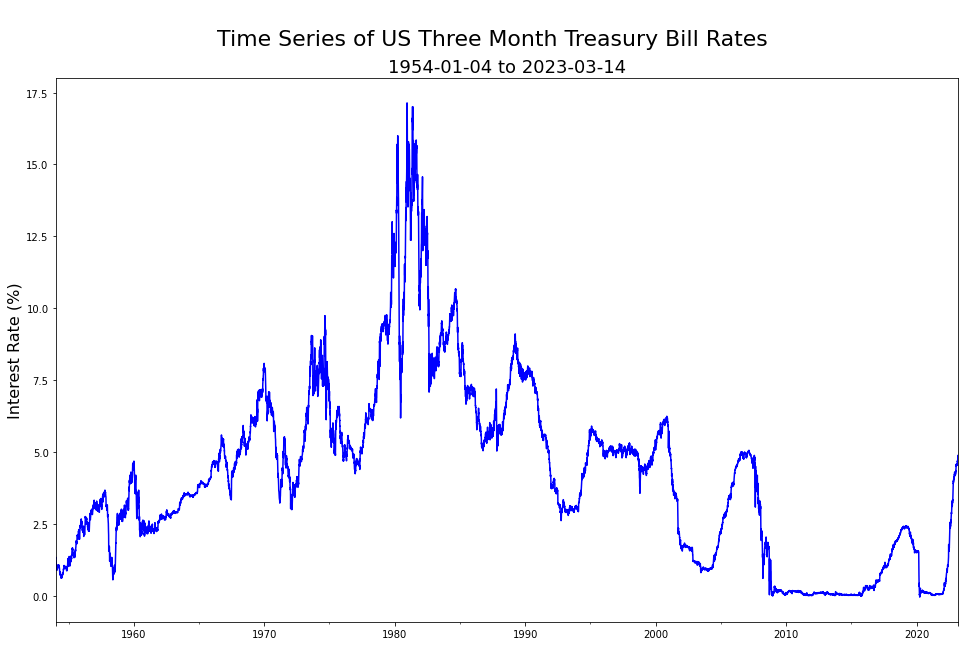

In [54]:
# get the bill rate data from Fred
DTB3=pd.read_table('https://fred.stlouisfed.org/data/DTB3.txt',skiprows=11,sep=r'\s+',header=0).rename(columns={"VALUE":"Rate","DATE":"Date"}).set_index("Date")
DTB3.index=pd.DatetimeIndex(DTB3.index).to_period('D')
DTB3['Rate']=DTB3['Rate'].apply(lambda x:float(x) if x!='.' else np.nan)

# join the recessions data (NBER data at Fred) 
USREC=pd.read_table('https://fred.stlouisfed.org/data/USREC.txt',skiprows=65,sep=r'\s+',header=0).rename(columns={"VALUE":"Recession","DATE":"Date"}).set_index("Date")
USREC.index=pd.DatetimeIndex(USREC.index).to_period('D')
DTB3=DTB3.merge(USREC,left_index=True,right_index=True,how='outer')
DTB3['Recession'].ffill(inplace=True)
DTB3['Recession']=DTB3['Recession'].apply(lambda x:True if x else False)
DTB3.dropna(inplace=True)
DTB3['Year']=DTB3.index.year
display(DTB3)

# Figure 2.14
figure,plot=pl.subplots(figsize=(10*GoldenRatio,10))
figure.suptitle("\nTime Series of US Three Month Treasury Bill Rates",fontsize=22)
plot.set_title("%s to %s" % (min(DTB3.index),max(DTB3.index)),fontsize=18)
DTB3['Rate'].plot(ax=plot,color='blue')
plot.set_xlabel(None)
plot.set_ylabel('Interest Rate (%)',fontsize=16);

In [56]:
DTB3.index[DTB3['Recession']!=DTB3['Recession'].shift()]

PeriodIndex(['1954-01-04', '1954-06-01', '1957-09-02', '1958-05-01',
             '1960-05-02', '1961-03-01', '1970-01-02', '1970-12-01',
             '1973-12-03', '1975-04-01', '1980-02-01', '1980-08-01',
             '1981-08-03', '1982-12-01', '1990-08-01', '1991-04-01',
             '2001-04-02', '2001-12-03', '2008-01-02', '2009-07-01',
             '2020-03-02', '2020-05-01'],
            dtype='period[D]', name='Date')

In [45]:
USREC[USREC.index>='1954-01-01'],DTB3[DTB3.index>='1954-01-01']

(            Recession
 Date                 
 1954-01-01          1
 1954-02-01          1
 1954-03-01          1
 1954-04-01          1
 1954-05-01          1
 ...               ...
 2022-10-01          0
 2022-11-01          0
 2022-12-01          0
 2023-01-01          0
 2023-02-01          0
 
 [830 rows x 1 columns],             Rate  Year  Recession
 Date                             
 1954-01-04  1.33  1954        NaN
 1954-01-05  1.28  1954        NaN
 1954-01-06  1.28  1954        NaN
 1954-01-07  1.31  1954        NaN
 1954-01-08  1.31  1954        NaN
 ...          ...   ...        ...
 2023-03-08  4.89  2023        NaN
 2023-03-09  4.87  2023        NaN
 2023-03-10  4.83  2023        NaN
 2023-03-13  4.70  2023        NaN
 2023-03-14  4.71  2023        NaN
 
 [18052 rows x 3 columns])